

[参考](https://blog.csdn.net/qq_26658823/article/details/79085736)。

得分：$0.12223$（目前我最好的分数）。


总结和思考：


1、数据平滑 log1p 以后，输出的时候要 expm1 回来；

2、有的字段值是数字，但实际上字符型的，要处理成字符型，最终变成独热编码，否则会引入有序关系：

```python
all_df.MSSubClass.astype(str)
```

3、一般机器学习的问题都会使用集成学习，集成学习的效果比单一学习器要好，泛化能力更强；

4、调参使用交叉验证，或者网格搜索。

欢迎批评和指导，我的联系方式：

1、电话、微信：13671597056；

2、QQ：121088825；

3、邮件地址：liweiwei1419@gmail.com。



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_df = pd.read_csv('../input/train.csv', index_col=0)
test_df = pd.read_csv('../input/test.csv', index_col=0)

In [3]:
train_df.shape

(1460, 80)

In [4]:
test_df.shape

(1459, 79)

In [5]:
# train_df.head()
# test_df.head()

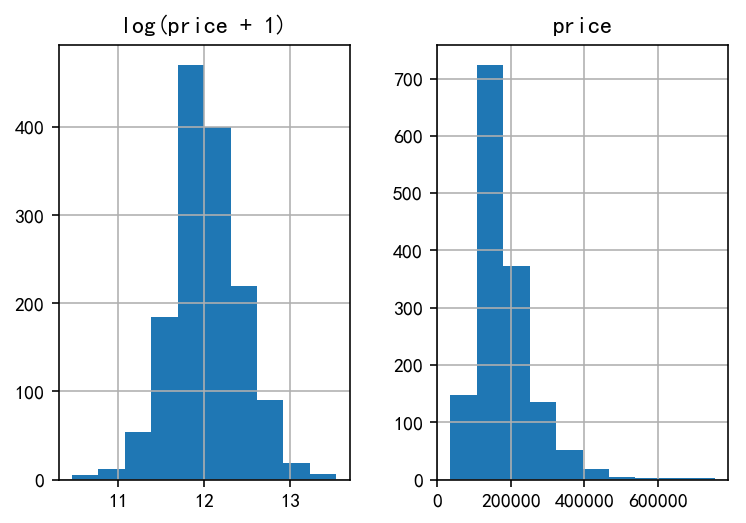

In [6]:
prices = pd.DataFrame({
    "price": train_df.SalePrice,
    "log(price + 1)": np.log1p(train_df.SalePrice)
})
prices.hist()
plt.show()

In [7]:
y_train = np.log1p(train_df['SalePrice'])
# train_df.drop(['SalePrice'], axis=1, inplace=True)
del train_df['SalePrice']

In [8]:
all_df = pd.concat((train_df, test_df), axis=0)
all_df.shape

(2919, 79)

MSSubClass 这个字段是字符型。

In [9]:
all_df.MSSubClass.dtypes

dtype('int64')

In [10]:
all_df.MSSubClass = all_df.MSSubClass.astype(str)

In [11]:
all_df.MSSubClass.value_counts()

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [12]:
pd.get_dummies(all_df.MSSubClass, prefix='MSSubClass').head()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [13]:
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


统计空值。

In [14]:
all_dummy_df.isnull().sum().sort_values(ascending=False).head()

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
dtype: int64

In [15]:
mean_cols = all_dummy_df.mean()
mean_cols.head()

LotFrontage       69.305795
LotArea        10168.114080
OverallQual        6.089072
OverallCond        5.564577
YearBuilt       1971.312778
dtype: float64

使用均值填充所有字段。

In [16]:
from sklearn.preprocessing import Imputer

# 使用这一行的平均值来填充，使用 axis 参数指定
imr = Imputer(missing_values='NaN', strategy='mean', axis=1)
imr.fit(all_dummy_df)
imputed_data = imr.transform(all_dummy_df)
imputed_data

/Users/liwei/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[6.5000e+01, 8.4500e+03, 7.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [8.0000e+01, 9.6000e+03, 6.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [6.8000e+01, 1.1250e+04, 7.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       ...,
       [1.6000e+02, 2.0000e+04, 5.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.2000e+01, 1.0441e+04, 5.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [7.4000e+01, 9.6270e+03, 7.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00]])

In [17]:
all_dummy_df = all_dummy_df.fillna(mean_cols)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


In [18]:
all_dummy_df.isnull().sum().sum()

0

In [19]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']
numeric_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

数值型变量标准化。

In [20]:
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std()
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std

In [21]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]

这么多特征。

In [22]:
dummy_train_df.shape, dummy_test_df.shape

((1460, 303), (1459, 303))

## 岭回归

In [23]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [24]:
X_train = dummy_train_df.values
X_test = dummy_test_df.values

直接用交叉验证，没有分割训练集与测试集。

In [25]:
%%time
alphas = np.logspace(-3, 2, 50)
test_scores = list()
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(
        clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

CPU times: user 29.7 s, sys: 8.07 s, total: 37.8 s
Wall time: 5.59 s


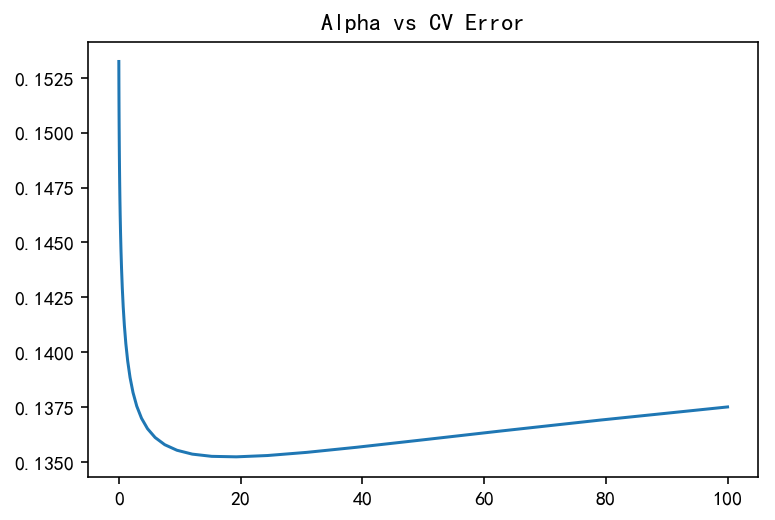

In [26]:
plt.plot(alphas, test_scores)
plt.title("Alpha vs CV Error")
plt.show()

用网格搜索试试看

In [27]:
np.set_printoptions(suppress=True, precision=4)

In [28]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

parameters = {'alpha': np.logspace(-3, 2, 50)}  # 50 个数
clf = Ridge()
grid = GridSearchCV(
    clf, parameters, cv=5, scoring='neg_mean_squared_error', verbose=2)

In [29]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.0s
[CV] alpha=0.0012648552168552957 .....................................
[CV] ...................... alpha=0.0012648552168552957, total=   0.0s
[CV] alpha=0.0012648552168552957 .....................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... alpha=0.002559547922699536, total=   0.0s
[CV] alpha=0.002559547922699536 ......................................
[CV] ....................... alpha=0.002559547922699536, total=   0.0s
[CV] alpha=0.002559547922699536 ......................................
[CV] ....................... alpha=0.002559547922699536, total=   0.0s
[CV] alpha=0.002559547922699536 ......................................
[CV] ....................... alpha=0.002559547922699536, total=   0.0s
[CV] alpha=0.002559547922699536 ......................................
[CV] ....................... alpha=0.002559547922699536, total=   0.0s
[CV] alpha=0.0032374575428176433 .....................................
[CV] ...................... alpha=0.0032374575428176433, total=   0.0s
[CV] alpha=0.0032374575428176433 .....................................
[CV] ...................... alpha=0.0032374575428176433, total=   0.0s
[CV] alpha=0.0032374575428176433 .....................................
[CV] .

[CV] ........................ alpha=0.04291934260128778, total=   0.0s
[CV] alpha=0.04291934260128778 .......................................
[CV] ........................ alpha=0.04291934260128778, total=   0.0s
[CV] alpha=0.04291934260128778 .......................................
[CV] ........................ alpha=0.04291934260128778, total=   0.0s
[CV] alpha=0.04291934260128778 .......................................
[CV] ........................ alpha=0.04291934260128778, total=   0.0s
[CV] alpha=0.054286754393238594 ......................................
[CV] ....................... alpha=0.054286754393238594, total=   0.0s
[CV] alpha=0.054286754393238594 ......................................
[CV] ....................... alpha=0.054286754393238594, total=   0.0s
[CV] alpha=0.054286754393238594 ......................................
[CV] ....................... alpha=0.054286754393238594, total=   0.0s
[CV] alpha=0.054286754393238594 ......................................
[CV] .

[CV] ......................... alpha=0.9102981779915218, total=   0.0s
[CV] alpha=0.9102981779915218 ........................................
[CV] ......................... alpha=0.9102981779915218, total=   0.0s
[CV] alpha=0.9102981779915218 ........................................
[CV] ......................... alpha=0.9102981779915218, total=   0.0s
[CV] alpha=0.9102981779915218 ........................................
[CV] ......................... alpha=0.9102981779915218, total=   0.0s
[CV] alpha=1.151395399326448 .........................................
[CV] .......................... alpha=1.151395399326448, total=   0.0s
[CV] alpha=1.151395399326448 .........................................
[CV] .......................... alpha=1.151395399326448, total=   0.0s
[CV] alpha=1.151395399326448 .........................................
[CV] .......................... alpha=1.151395399326448, total=   0.0s
[CV] alpha=1.151395399326448 .........................................
[CV] .

[CV] ......................... alpha=15.264179671752334, total=   0.0s
[CV] alpha=15.264179671752334 ........................................
[CV] ......................... alpha=15.264179671752334, total=   0.0s
[CV] alpha=19.306977288832496 ........................................
[CV] ......................... alpha=19.306977288832496, total=   0.0s
[CV] alpha=19.306977288832496 ........................................
[CV] ......................... alpha=19.306977288832496, total=   0.0s
[CV] alpha=19.306977288832496 ........................................
[CV] ......................... alpha=19.306977288832496, total=   0.0s
[CV] alpha=19.306977288832496 ........................................
[CV] ......................... alpha=19.306977288832496, total=   0.0s
[CV] alpha=19.306977288832496 ........................................
[CV] ......................... alpha=19.306977288832496, total=   0.0s
[CV] alpha=24.420530945486497 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([  0.001  ,   0.00126,   0.0016 ,   0.00202,   0.00256,   0.00324,
         0.00409,   0.00518,   0.00655,   0.00829,   0.01048,   0.01326,
         0.01677,   0.02121,   0.02683,   0.03393,   0.04292,   0.05429,
         0.06866,   0.08685,   0.10985,   0.13895,   0.17575...     19.30698,  24.42053,  30.88844,  39.0694 ,  49.41713,  62.50552,
        79.06043, 100.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [30]:
grid.best_estimator_

Ridge(alpha=15.264179671752334, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [31]:
grid.best_score_

-0.01979647338702152

In [32]:
grid.best_params_

{'alpha': 15.264179671752334}

## 随机森林回归

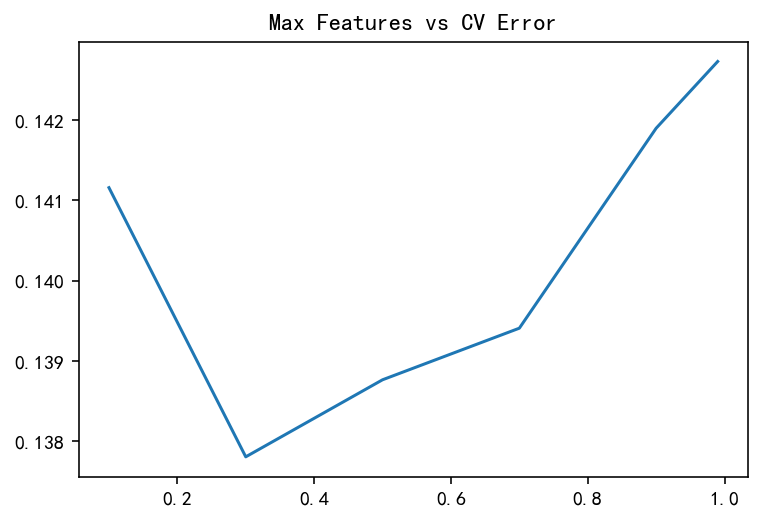

In [33]:
from sklearn.ensemble import RandomForestRegressor

max_features = [.1, .3, .5, .7, .9, .99]
test_scores = list()
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators=200, max_features=max_feat)
    test_score = np.sqrt(-cross_val_score(
        clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
plt.plot(max_features, test_scores)
plt.title("Max Features vs CV Error")
plt.show()

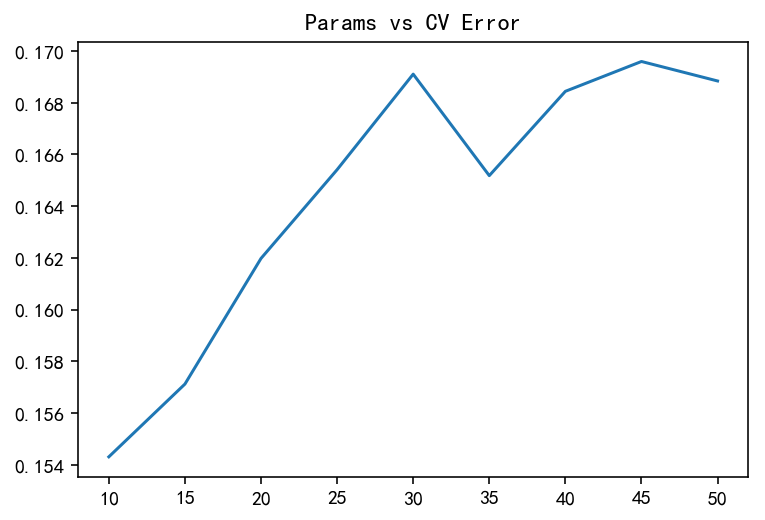

In [34]:
from sklearn.ensemble import AdaBoostRegressor

params = [10, 15, 20, 25, 30, 35, 40, 45, 50]
test_scores = list()
for param in params:
    clf = AdaBoostRegressor(n_estimators=param, base_estimator=Ridge(15))
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
plt.plot(params, test_scores)
plt.title("Params vs CV Error")
plt.show()

In [35]:
from sklearn.ensemble import BaggingRegressor

bg = BaggingRegressor(n_estimators=25, base_estimator=Ridge(15))
bg.fit(X_train, y_train)
y_final = np.expm1(bg.predict(X_test))

最后使用岭回归的袋装集成方法。

In [36]:
submission_df = pd.DataFrame(data={"Id": test_df.index, 'SalePrice': y_final})
submission_df.head()

,Id,SalePrice
0,1461,115750.549064
1,1462,149124.542018
2,1463,172294.149456
3,1464,195866.118756
4,1465,195799.628771


In [37]:
submission_df.to_csv('../output/submission_20190323.csv',index=False)